In [1]:
pwd

'D:\\Proj_OCR'

In [2]:
import cv2
import torch
from PIL import Image
import cv2
import torch
from PIL import Image
import glob
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.image as mpimg
import os
from pyzbar.pyzbar import decode
from pyzbar import pyzbar
import cv2
import glob
from tqdm import tqdm
from barcode import EAN13
from barcode.writer import ImageWriter
import matplotlib.pyplot as plt

import cv2
import torch
from PIL import Image

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

from pylibdmtx.pylibdmtx import decode as decodeMatrix
from PIL import Image

%matplotlib inline

In [3]:
#YOLO model loading - detect locations of labels
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./best_sticker_OCR_All.pt')
model.iou = 0.1
print(type(model))

Using cache found in C:\Users\sendr/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2021-12-9 torch 1.8.2+cu111 CUDA:0 (GeForce RTX 3050 Laptop GPU, 4096MiB)

Fusing layers... 
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


<class 'models.common.AutoShape'>


###### Data Matrix: Init all at once

In [4]:
class DataMatrix:
    def __init__ (self, stickerImage, decodedData):
        self.Data = str(decodedData[0][0]).split(' {')
        self.MetaData = decodedData[0][1]
        self.Image = stickerImage
        
        #Extract Information
        self.PN = int(self.Data[0].split("'")[-1])
        self.QTY = int(self.Data[1])
        self.VENDOR = self.Data[3]
        self.DC = int(self.Data[4])
        self.Other = [self.Data[5], self.Data[6], self.Data[7]]
        
        # What & Where to Write: bounding box and write the info
        #Text
        self.TextList = ['VENDOR:'+str(self.VENDOR),
                        'P/N:'+str(self.PN), 
                         'QTY:'+str(self.QTY), 
                         'D/C: '+str(self.DC), 
                         "Other_Info: ",
                         str(self.Other[0]),
                         str(self.Other[1]),
                         str(self.Other[2])]
        #Bounding Box
        h,w,_ = stickerImage.shape
        start_point = (self.MetaData.left + self.MetaData.width,h-self.MetaData.top)
        end_point = (self.MetaData.left, h-self.MetaData.top - self.MetaData.height)
        
        thickness = int(0.01*h)
        
        #Draw rectangle
        cv2.rectangle (stickerImage, start_point, end_point, (0,0,255), thickness)
        
        start_point2 = (self.MetaData.left + self.MetaData.width, h-self.MetaData.top - self.MetaData.height)
        end_point2 = (self.MetaData.left + self.MetaData.width, h-self.MetaData.top - self.MetaData.height-self.MetaData.height//2)
        cv2.line(stickerImage, start_point2, end_point2, (0,0,255), thickness)
        
        a = end_point2 [0]
        b = end_point2 [1]
        
        fontsize = float(1/1280*w)
        
        i = 0
        for text in self.TextList:
            cv2.putText(stickerImage, text, (a,b), cv2.FONT_HERSHEY_SIMPLEX, fontsize, (255,0,0), 1, cv2.LINE_AA)
            b += int(30/1280*w)
            i +=0
 

In [5]:
files  =glob.glob('./Sample_Images/DataMatrix/*.jpg')

imgs = []

for file in tqdm(files):
    imgs.append(cv2.imread(file))
    

data_matrix_list = []


for i in tqdm(range (len(imgs))):
    try:
        decod_result = decodeMatrix (imgs[i])
        data_matrix_list.append (DataMatrix(imgs[i], decod_result))
    except:
        #print('No Data Matrix')
        continue
    
#output result
i = 0
for data_matrix in tqdm(data_matrix_list):
    cv2.imwrite('./Sample_Images/DataMatrix/res_'+str(i)+'.jpg',data_matrix.Image)
    i +=1

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13.65it/s]


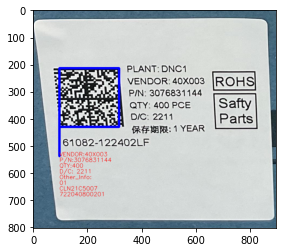

In [18]:
plt.imshow(data_matrix_list[1].Image)

In [18]:
# Functions

# binarizing image alg.
def binarizeImage (image, tresh_value = 127):
    grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, tresh_value, 255, cv2.THRESH_BINARY)
    #plt.imshow(blackAndWhiteImage)
    return blackAndWhiteImage

# read OCR algorithm
def readOCR(image):
        total_letter = ''
        hImg, wImg, _ = image.shape  
        #hImg, wImg = binarizedImage.shape
        #image = binarizeImage (image, treshold)
        boxes = pytesseract.image_to_boxes(image)
        total_letter = ''
        
        for b in boxes.splitlines():
            b = b.split(' ')
            x,y,w,h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
            start_point = (x, hImg -y)
            end_point = (w, hImg -h)
            mid_point = ((x+w)//2, (start_point[1]+end_point[1])//2)
            write_point = (mid_point[0],end_point[1])
            total_letter+=b[0]
            
        return total_letter
    
# read OCR algorithm2: alternative    
def readOCRBinary(binarizedImage):
        total_letter = ''
        #hImg, wImg, _ = image.shape  
        hImg, wImg = binarizedImage.shape
        #image = binarizeImage (image, treshold)
        boxes = pytesseract.image_to_boxes(image)
        total_letter = ''
        
        for b in boxes.splitlines():
            b = b.split(' ')
            x,y,w,h = int(b[1]), int(b[2]), int(b[3]), int(b[4])
            start_point = (x, hImg -y)
            end_point = (w, hImg -h)
            mid_point = ((x+w)//2, (start_point[1]+end_point[1])//2)
            write_point = (mid_point[0],end_point[1])
            total_letter+=b[0]
            
        return total_letter

# read barcode: only 1D, 2D QR work, 2D matrix not work   
def readBarcode (stickerObject): 
    barcodes = decode(stickerObject.binarizedImage)
    

    if (len(barcodes) > 0):
        print ('Barcode detected')
        k = 0
        for barcode in barcodes:
        
            (x, y, w, h) = barcode.rect
        #cv2.rectangle(originalImage, (x, y), (x + w, y + h), (0, 0, 255), thickness=2)
            barcodeData = barcode.data.decode("utf-8")
            barcodeType = barcode.type
            barcode_object = Barcode(barcodeData, barcodeType, [(x, y), (x + w, y + h)])
        
            stickerObject.barcodeList.append(barcode_object)
        
        #list_locationPoints.append(((x, y), (x + w, y + h)))
        
        #list_barcodeData.append(barcodeData)
        
        #list_barcodeType.append(barcodeType)
            
            text = "{} ({})".format(barcodeData, barcodeType)
        
        #text = "{}".format(barcodeData)
            bbObject = BoundingBox((x, y), (x + w, y + h), text)
        
            stickerObject.barcodeList[k].boundingBox = bbObject
            
            fontsize = float(1/1280*stickerObject.image.shape[1])
            thickness = int(0.01*stickerObject.image.shape[1])
        
            cv2.putText(stickerObject.image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, fontsize, (255, 0, 0), thickness)
            cv2.rectangle(stickerObject.image, (x, y),  (x + w, y + h), (255, 0, 0), thickness)
            k +=1

    else:
        print ('1D/2D Barcode not detected')
    


class Sticker:
    def __init__(self, image = None):
        #general identity
        self.image = image
        self.binarizedImage = binarizeImage(image)
        
        #OCR purpose
        self.results = []
        self.Attributes = []
        self.Contents = []
        
        #Barcode purpose
        self.barcodeList = []
        
        
class StickerType2:
    def __init__(self, image = None):
        #general identity
        self.image = image
        self.binarizedImage = binarizeImage(image)
        
        #OCR purpose
        self.results = []
        self.Attributes = []
        self.Contents = []
        
        #DataMatrix purpose
        self.DMVendor = None
        self.DMPN = None
        self.DMQTY = None
        self.DMDC = None
        self.OtherInfo = []
        
    
'''class Data:
    def __init__(self, Attribute, Content):
        self.Attribute = None
        self.Content = None'''


## OCR Purpose        
class Attribute:
    def __init__(self, start_point, end_point, middle_point, image):    
        self.start_point = start_point
        self.end_point = end_point
        self.middle_point = middle_point
        
        self.xmin = start_point[0]
        self.ymin = start_point[1]
        
        self.xmax = end_point[0]
        self.ymax = end_point[1]
        
        self.xmid = (self.xmin + self.xmax)//2
        self.ymid = (self.ymin + self.ymax)//2
        
        self.image = image[ymin:ymax,xmin:xmax]
        
        self.binarizedImage = None
        self.OCR = None
        self.WriteSpot = (self.xmid, self.ymin)
        
        
       
class Content:
    def __init__(self, start_point, end_point, middle_point, image):       
        self.start_point = start_point
        self.end_point = end_point
        self.middle_point = middle_point
        
        self.xmin = start_point[0]
        self.ymin = start_point[1]
        
        self.xmax = end_point[0]
        self.ymax = end_point[1]
        
        self.xmid = (self.xmin + self.xmax)//2
        self.ymid = (self.ymin + self.ymax)//2
        
        self.image = image [ymin:ymax,xmin:xmax]
        
        self.binarizedImage = None
        self.OCR = None
        self.WriteSpot = (self.xmax, self.ymid)
        #self.WriteSpot = (xmax, ymid)
        
        
# Barcode Purpose: 1d and 2d
class Barcode:
    def __init__(self,  barcodeContent, barcodeType, originAddress):
        self.barcodeContent = barcodeContent
        self.barcodeType = barcodeType
        self.boundingBox = None
        

class BoundingBox:
     def __init__(self, initPosition, finalPosition, theText):
         self.initPosition = initPosition
         self.finalPosition = finalPosition
         self.theText = theText
         self.color = (0,0,255)
    

In [21]:
files = glob.glob('./Sample_Images/DataMatrix/*.jpg')
len(files)

3

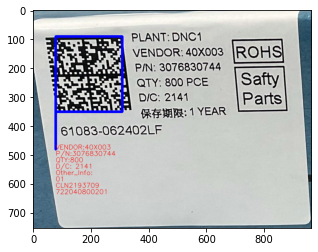

In [22]:
%matplotlib inline

plt.imshow(imgs[2])

In [23]:
#Operation on each stickers

#files = glob.glob('./Sample_Images/DataMatrix/*.jpg')

sticker_list = []  # batch of images

#read each file of sticker images
for file in tqdm(files):
    sticker_list.append(Sticker(cv2.imread(file)))
    
'''for img in tqdm(imgs):
    sticker_list.append(Sticker(img))'''
    
#convert BGR to RGB
for i in range (len(sticker_list)):
    sticker_list[i].image = cv2.cvtColor(sticker_list[i].image, cv2.COLOR_BGR2RGB)
    
for i in range (len(sticker_list)):
    sticker_list[i].results = model(np.copy(sticker_list[i].image))    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.41it/s]


In [24]:
# Add list of attributes and content in images

for i in tqdm(range (len(sticker_list))):
    df = sticker_list[i].results.pandas().xyxy[0]
    df_att = df.loc[df['name']=='attributes']
    df_data = df.loc[df['name']!='attributes']
    
    if (len(df) < 1):
        continue
        
    #Add Attributes
    for j in range(len(df_att)):
        xmin = int(df_att.iloc[j].xmin)
        ymin = int(df_att.iloc[j].ymin)
        xmax = int(df_att.iloc[j].xmax)
        ymax = int(df_att.iloc[j].ymax)
        
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        mid_point = ((xmin+xmax)//2, (ymin+ymax)//2)
        image = sticker_list[i].image
        sticker_list[i].Attributes.append(Attribute(start_point, end_point, mid_point, image))
    
    #Add Data (Content) to list in sticker objects
    for j in range(len(df_data.index)):
        xmin = int(df_data.iloc[j].xmin)
        ymin = int(df_data.iloc[j].ymin)
        xmax = int(df_data.iloc[j].xmax)
        ymax = int(df_data.iloc[j].ymax)
        
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        mid_point = ((xmin+xmax)//2, (ymin+ymax)//2)
        image = sticker_list[i].image
        sticker_list[i].Contents.append(Content(start_point, end_point, mid_point, image))


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33.08it/s]


None


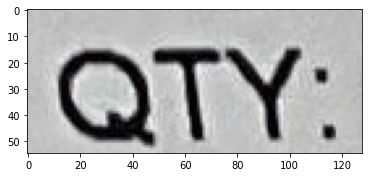

In [25]:
#TEST
i = 0
j = 0

%matplotlib inline
plt.imshow(sticker_list[i].Attributes[j].image)
print(sticker_list[i].Attributes[j].OCR)

In [26]:
# set the OCR read for all stickers in each labels:
for sticker in tqdm(sticker_list):
    for attribute in sticker.Attributes:
        attribute.binarizedImage = binarizeImage(attribute.image)
        attribute.OCR = readOCR(attribute.image)
        
    for content in sticker.Contents:
        content.binarizedImage = binarizeImage(content.image)
        content.OCR = readOCR(content.image)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.21s/it]


In [27]:
#WRITE ALL TO THE IMAGE
for i in tqdm(range(len(sticker_list))):
    
    #Attributes
    #print('Writing attributes....')
    for attribute in sticker_list[i].Attributes:
        text = attribute.OCR
        coordinates = attribute.WriteSpot
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = sticker_list[i].image.shape[1]*1/1280
        color =  (255,0,0)
        thickness = int(sticker_list[i].image.shape[1]*0.01)        
        #cv2.rectangle(sticker_list[i].image, attribute.start_point, attribute.end_point, color, 2)
        cv2.rectangle(imgs[i], attribute.start_point, attribute.end_point, color, 2)
        
        #cv2.putText(sticker_list[i].image, text, coordinates, font, fontScale, color, 1, cv2.LINE_AA)
        cv2.putText(imgs[i], text, coordinates, font, fontScale, color, 1, cv2.LINE_AA)
        
    
    #Content
    #print('Writing content....')
    for content in sticker_list[i].Contents:
        text = content.OCR
        coordinates = content.WriteSpot
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = sticker_list[i].image.shape[1]*1/1280
        color =  (0,0,255)
        thickness = int(sticker_list[i].image.shape[1]*0.01) 
        
        cv2.rectangle(imgs[i], content.start_point, content.end_point, color, 2)
        cv2.putText(imgs[i], text, coordinates, font, fontScale, color, 1, cv2.LINE_AA)
        
print('Finished')

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 657.28it/s]

Finished


In [28]:
# Read Barcode
for sticker in tqdm(sticker_list):
    readBarcode (sticker)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.63it/s]

1D/2D Barcode not detected
1D/2D Barcode not detected
1D/2D Barcode not detected


In [15]:
'''i = 0
for sticker in tqdm(sticker_list):
    cv2.imwrite('./Sample_Images/DataMatrix/resocr_'+str(i)+'.jpg',sticker.image[:,:,::-1])
    i +=1'''

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 55.74it/s]


In [30]:
i = 0
for img in tqdm(imgs):
    cv2.imwrite('./Sample_Images/DataMatrix/resocr_'+str(i)+'.jpg',img[:,:,::-1])
    i +=1

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.59it/s]
